In [30]:
import os

import numpy as np
import matplotlib.pyplot as plt
import json

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import model_from_json

# unused for now, to be used for ROC analysis
from sklearn.metrics import roc_curve, auc



# the size of the images in the PCAM dataset
IMAGE_SIZE = 96


In [10]:
def get_pcam_generators(base_dir, train_batch_size=32, val_batch_size=32):

     # dataset parameters
     TRAIN_PATH = os.path.join(base_dir, 'train+val', 'train')
     VALID_PATH = os.path.join(base_dir, 'train+val', 'valid')

     RESCALING_FACTOR = 1./255
     
     # instantiate data generators
     datagen = ImageDataGenerator(rescale=RESCALING_FACTOR)

     train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=train_batch_size,
                                             class_mode='binary')

     val_gen = datagen.flow_from_directory(VALID_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=val_batch_size,
                                             class_mode='binary',
                                             shuffle=False)
     
     return train_gen, val_gen

In [11]:
def get_model(kernel_size=(3,3), pool_size=(4,4), first_filters=32, second_filters=64):


     # build the model
     model = Sequential()

     model.add(Conv2D(first_filters, kernel_size, activation = 'relu', padding = 'same', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
     model.add(MaxPool2D(pool_size = pool_size)) 

     model.add(Conv2D(second_filters, kernel_size, activation = 'relu', padding = 'same'))
     model.add(MaxPool2D(pool_size = pool_size))

     model.add(Flatten())
     model.add(Dense(64, activation = 'relu'))
     model.add(Dense(1, activation = 'sigmoid'))
     
    
     # compile the model
     model.compile(SGD(lr=0.01, momentum=0.95), loss = 'binary_crossentropy', metrics=['accuracy'])

     return model

In [8]:
# get the model
model = get_model()

# get the data generators
train_gen, val_gen = get_pcam_generators("C:/Users/20192236/Documents/Project_Imaging/")

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [6]:
for layer in model.layers:
    print(layer.output_shape)

(None, 96, 96, 32)
(None, 24, 24, 32)
(None, 24, 24, 64)
(None, 6, 6, 64)
(None, 2304)
(None, 64)
(None, 1)


In [7]:
# save the model and weights
model_name = 'my_first_cnn_model'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 


# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]


# train the model
train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size

history = model.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=3,
                    callbacks=callbacks_list)

Epoch 1/3
1946/4500 [===========>..................] - ETA: 9:46 - loss: 0.5376 - accuracy: 0.7258

KeyboardInterrupt: 

In [ ]:
import winsound
winsound.Beep(1000,1000)

# Exercise 1

In [43]:
model = tensorflow.keras.models.load_model(r'C:\Users\20192236\Documents\Project_Imaging\my_first_cnn_model_weights.hdf5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2304)              0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [44]:
y_pred_keras=model.predict(val_gen).ravel()

In [45]:
y_true = val_gen.labels

In [46]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

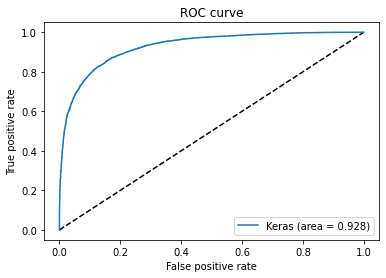

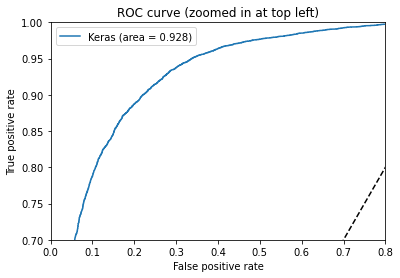

In [48]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.8)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()